# Hello, this my first time using TF

### Goals:
- Implement a DNN with TF

##### Note that this implementation is heavily inspired from courses from Arthur Douillard: https://m2dsupsdlclass.github.io/lectures-labs/

In [339]:
import tensorflow as tf
import numpy as np

In [379]:
def init_weights(shape, stddev=0.01, mean=0):
    return tf.Variable(tf.random.normal(shape, stddev=stddev, mean=mean))

def apply_activation(activation, z_n):
    dic = {
        "relu": tf.keras.activations.relu,
        "sigmoid": tf.nn.sigmoid,
        "softmax": tf.nn.softmax,
        "tanh": tf.math.tanh,
        "linear": tf.keras.activations.linear
        # Add more of your functions if you need
    }
    
    return dic[activation](z_n) # Put your parameters if needed

def accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == y)


def test_model(model, x, y):
    dataset = gen_dataset(x, y)
    preds, targets = [], []
    
    for batch_x, batch_y in dataset:
        preds.append(model(batch_x).numpy())
        targets.append(batch_y.numpy())
     
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    return accuracy(preds, targets)

def format_activations(layers, activations):
    # We should and always have n - 1 elts in activations if layers has n
    l = []
    i = 0
    while (i < len(layers) - 2):
        if (i < len(activations) - 1):
            l.append(activations[i])
        else: # We consider that the last layer should be kept for the last
            l.append(activations[len(activations) - 2])
        i += 1
    l.append(activations[len(activations) - 1])
    return l

In [380]:
class L_Layer_Model:
    # We consider layer to be [input, h1, h2, h3, ..., output]
    def __init__(self, layers, activations):
        activations = format_activations(layers, activations)
        values = []
        initializer = tf.keras.initializers.GlorotUniform()
        for i in range(1, len(layers)):
            values.append(tf.Variable(
                    initializer(shape=(layers[i-1], layers[i]))
                ))
            values.append(tf.Variable(tf.zeros([layers[i]])))
        self.values = values
        self.activations = activations
        
    def __call__(self, inputs):
        if len(self.values) == 0:
            raise Exception("0 Layer Model?")
        z1 = tf.matmul(inputs, self.values[0]) + self.values[1]
        a1 = apply_activation(self.activations[0], z1)
        idx = 2
        # Leaving the activation of the last layer for tf functions
        for i in range(2, len(layers)):
            z1 = tf.matmul(a1, self.values[idx]) + self.values[idx + 1]
            a1 = apply_activation(self.activations[i - 1], z1)
            idx += 2
        return a1
    
    def forward(self, x):
        return self(x)
    
    def train(self, X_train, y_train, X_test, y_test,
             num_epochs = 10,
             batch_size = 32,
             optimizer = optimizers.SGD(learning_rate = 0.1,
                                  momentum = 0.9,
                                  nesterov = True),
             verbose = True,
             loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits):
        
        losses = []
        accuracies = []
        for e in range(num_epochs):
            train_dataset = gen_dataset(X_train, y_train, batch_size)

            for batch_x, batch_y in train_dataset:
                with tf.GradientTape() as tape:
                    logits = self.forward(batch_x)
                    loss = tf.reduce_mean(loss_fn(batch_y, logits))
                    
                    losses.append(loss.numpy())
                grads = tape.gradient(loss, self.values)
                optimizer.apply_gradients(zip(grads, self.values))

            train_accuracy = test_model(self, X_train, y_train)
            test_accuracy = test_model(self, X_test, y_test)

            accuracies.append(test_accuracy)
            
            if (verbose):
                print(f"Epoch {e}, train_acc = {round(train_accuracy, 4)}, test_acc = {round(test_accuracy, 4)}, loss = {round(losses[len(losses) - 1], 4)}")
        if (verbose):
            print()
        return losses, accuracies

#### Let's test this !

Text(0.5, 1.0, 'Image Label: 0')

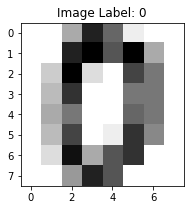

In [381]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

sample_idx = 0

plt.figure(figsize=(3,3))
plt.imshow(digits.images[sample_idx], cmap=plt.cm.gray_r,
          interpolation='nearest')

plt.title(f"Image Label: {digits.target[sample_idx]}")

#### Preprocessing
- Normalize
- Train Test Split

In [382]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.15,
                                                   random_state=37)
# We put a random state to have reproducible results

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # Center and normalize
X_test = scaler.fit_transform(X_test)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((1527, 64), (1527,)), ((270, 64), (270,)))

In [383]:
from tensorflow.keras import optimizers # Get optimizers

def gen_dataset(x, y, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=10000, seed=42)
    dataset = dataset.batch(batch_size=batch_size)
    
    return dataset

def test_single_model(layers, activations,
                      X_train, y_train, X_test, y_test,
                      num_epochs = 15,
                      batch_size = 32,
                      optimizer = optimizers.SGD(learning_rate = 0.1,
                                  momentum = 0.9,
                                  nesterov = True),
                      verbose=True,
                      loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits
                            ):
    
    model = L_Layer_Model(layers, activations)
    print("Activations: ", model.activations)
    if (verbose):
        print(f"Without Training: {test_model(model, X_train, y_train)}")
    losses, accuracies = model.train(X_train, y_train, X_test, y_test,
                                     num_epochs, batch_size, optimizer, verbose, loss_fn)
    return model, losses, accuracies


def test_models(layers, activations_list, 
                X_train, y_train, X_test, y_test,
                num_epochs = 15,
                batch_size = 32,
                optimizer = optimizers.SGD(learning_rate = 0.1,
                            momentum = 0.9,
                            nesterov = True),
                verbose=True,
                loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits):
    models = []
    all_losses = []
    all_accuracies = []
    for activations in activations_list:
        model, losses, accuracies = test_single_model(layers, activations, X_train, y_train, X_test, y_test, 
                                        num_epochs = num_epochs, batch_size = batch_size,
                                       optimizer = optimizer, verbose=verbose,
                                        loss_fn = loss_fn)
        models.append(model)
        all_losses.append(losses)
        all_accuracies.append(accuracies)
    return models, all_losses, all_accuracies

def plot_all_losses(activations_list, all_losses, all_accuracies):
    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 1)
    for i in range(len(all_losses)):
        plt.plot(all_losses[i], label=str(activations_list[i]))
    plt.ylabel("Loss Cost")
    plt.xlabel("Nb iter")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i in range(len(all_losses)):
        plt.plot(all_accuracies[i], label=str(activations_list[i]))
    plt.ylabel("Accuracy Test Set")
    plt.xlabel("Nb epoch")
    plt.legend()
    
    plt.show()

Activations:  ['sigmoid', 'softmax']
Activations:  ['relu', 'softmax']
Activations:  ['tanh', 'softmax']


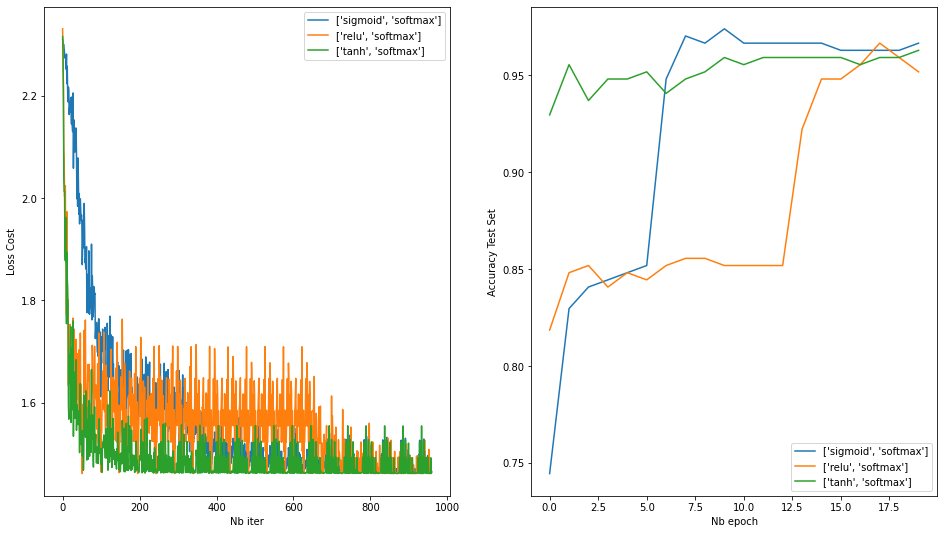

In [384]:
layers = [X_train.shape[1], 15, 10]
# Linear in the output because it will go into the softmax
activations_list = [["sigmoid", "softmax"],
                   ["relu", "softmax"],
                   ["tanh", "softmax"]]
#optimizer = optimizers.SGD(learning_rate = 0.1, momentum=0.9, nesterov=True)
optimizer = optimizers.Adam(learning_rate=0.01)

models, all_losses, all_accuracies = test_models(layers, activations_list, X_train, y_train, X_test, y_test, 
                                                 num_epochs=20, optimizer = optimizer, verbose=False)

plot_all_losses(activations_list, all_losses, all_accuracies)

#### Let's test iris dataset, classification aswell

In [385]:
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

iris = load_iris() # Iris only have 3 classes

data = np.asarray(iris.data, dtype='float32')
target = np.asarray(iris.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.15,
                                                   random_state=37)
# We put a random state to have reproducible results

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # Center and normalize
X_test = scaler.fit_transform(X_test)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((127, 4), (127,)), ((23, 4), (23,)))

Activations:  ['sigmoid', 'softmax']
Activations:  ['relu', 'softmax']
Activations:  ['tanh', 'softmax']


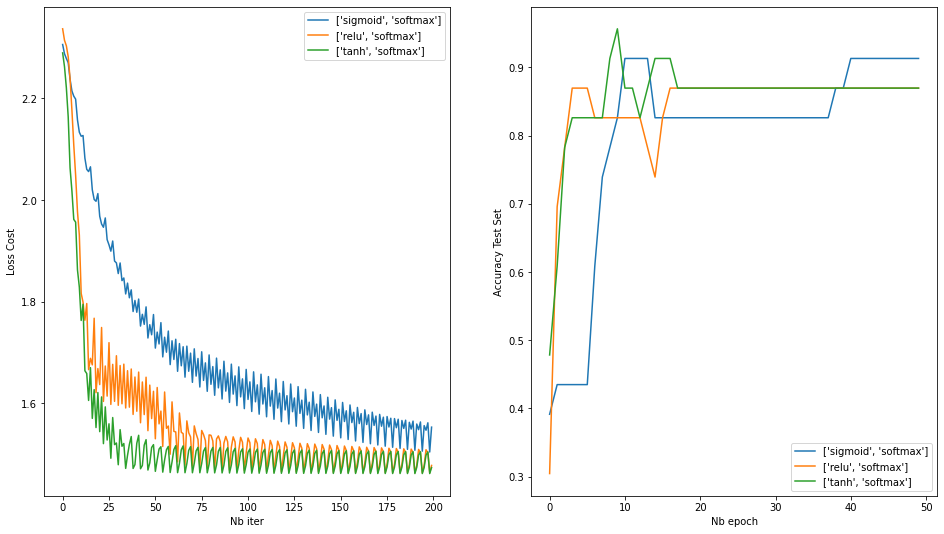

In [386]:
layers = [X_train.shape[1], 15, 10]
# Linear in the output because it will go into the softmax
activations_list = [["sigmoid", "softmax"],
                   ["relu", "softmax"],
                   ["tanh", "softmax"]]
# optimizer = optimizers.SGD(learning_rate = 0.1, momentum=0.9, nesterov=True)
optimizer = optimizers.Adam(learning_rate=0.01)
models, all_losses, all_accuracies = test_models(layers, activations_list, X_train, y_train, X_test, y_test, 
                                                 num_epochs=50, optimizer = optimizer, verbose=False)

plot_all_losses(activations_list, all_losses, all_accuracies)

In [387]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

boston = load_boston() # Iris only have 3 classes

data = np.asarray(boston.data, dtype='float32')
target = np.asarray(boston.target, dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.15,
                                                   random_state=37)
# We put a random state to have reproducible results

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # Center and normalize
X_test = scaler.fit_transform(X_test)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((430, 13), (430,)), ((76, 13), (76,)))

In [390]:
def accuracy(y_pred, y):
    return np.mean(abs(y_pred - y))

Activations:  ['sigmoid', 'relu', 'linear']
Without Training: 22.83449935913086
Epoch 0, train_acc = 19.21339988708496, test_acc = 21.152999877929688, loss = 436.035400390625
Epoch 1, train_acc = 15.937800407409668, test_acc = 17.861499786376953, loss = 322.94110107421875
Epoch 2, train_acc = 12.20300006866455, test_acc = 14.03320026397705, loss = 213.7554931640625
Epoch 3, train_acc = 8.68280029296875, test_acc = 10.642000198364258, loss = 127.90540313720703
Epoch 4, train_acc = 6.587900161743164, test_acc = 8.74940013885498, loss = 82.168701171875
Epoch 5, train_acc = 6.2621002197265625, test_acc = 8.263400077819824, loss = 70.91089630126953
Epoch 6, train_acc = 6.4369001388549805, test_acc = 8.317700386047363, loss = 71.77079772949219
Epoch 7, train_acc = 6.382999897003174, test_acc = 8.285799980163574, loss = 71.4551010131836
Epoch 8, train_acc = 6.317399978637695, test_acc = 8.262800216674805, loss = 71.01129913330078
Epoch 9, train_acc = 6.301700115203857, test_acc = 8.2613000869

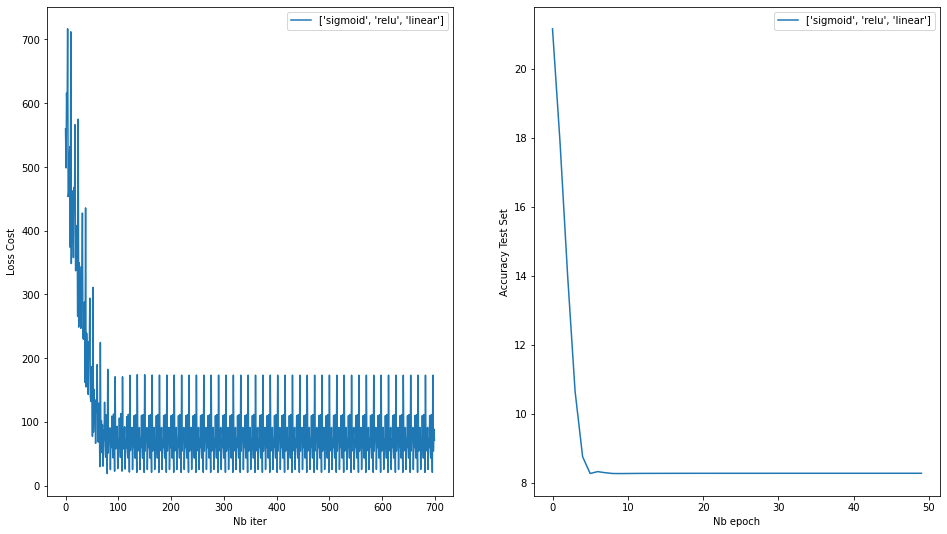

In [398]:
layers = [X_train.shape[1], 128, 64, 1] # Last layer size 1, output as a price
# Linear in the output because it will go into the softmax
activations_list = [ # Linear instead of softmax
                   ["sigmoid","relu", "linear"]
                   ]
optimizer = optimizers.Adam()
loss_fn = tf.keras.losses.MSE 
# Since we predict price, let's use MSE instead of cross-entropy
# which wouldn't really make sense...
models, all_losses, all_accuracies = test_models(layers, activations_list, X_train, y_train, X_test, y_test, 
                                                 num_epochs=50, verbose=True,
                                                loss_fn = loss_fn, batch_size=32,
                                                optimizer=optimizer)

plot_all_losses(activations_list, all_losses, all_accuracies)

Error:  71.88429


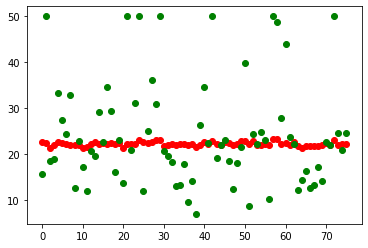

In [399]:
from sklearn.metrics import mean_squared_error

y_train_pred = models[0](X_train).numpy()
print("Error: ", mean_squared_error(y_train, y_train_pred).mean())

y_pred = models[0](X_test).numpy() # We take the RELu one
x = np.arange(0, len(X_test))
plt.scatter(x, y_pred, color='red') # Prediction
plt.scatter(x, y_test, color='green')

plt.show()

## Basically we are overfitting, let's add some regularization, let's say L1 regularization to maybe silence some variables

Error:  17.368946


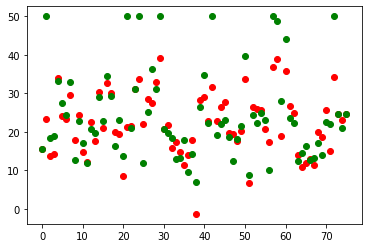

In [328]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

clf = LinearRegression()
clf.fit(X_train, y_train)
# Error
y_train_pred = clf.predict(X_train)
print("Error: ", mean_squared_error(y_train, y_train_pred).mean())


y_pred = clf.predict(X_test)
x = np.arange(0, len(X_test))
plt.scatter(x, y_pred, color='red') # Prediction
plt.scatter(x, y_test, color='green')

plt.show()
